In [1]:
## Import data
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

PRESSURE_PATH = '/home/ubuntu/CAAM/496_New_Data/pressure/'   # pressure data
SATURATION_PATH = '/Users/jiujiu/Desktop/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/Users/jiujiu/Desktop/496_New_Data/production/' # production data
ROCK_PATH = '/Users/jiujiu/Desktop/496_New_Data/rock/'

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pullporosity(ROCK_PATH, index_list):
    data = []
    for i in index_list:
        temp_data = np.loadtxt(ROCK_PATH + '/rock'+str(i)+'.txt', delimiter=',')
        data.append(temp_data[[0]])
    data = np.float32(data)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
        
def animate_encoded(X,decoder,index_range):
    # sanity check on stacked encoded space
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
#     print(X.shape)
    decoded_X = decoder.predict(X[:,:,:,index_range])
#     print(decoded_X)
    for i in range(len(decoded_X)):
        ax1.clear()
        ax1.imshow(np.reshape(decoded_X[i],(60,220),order = 'F'))
        fig.canvas.draw()
        plt.pause(0.01)

<IPython.core.display.Javascript object>


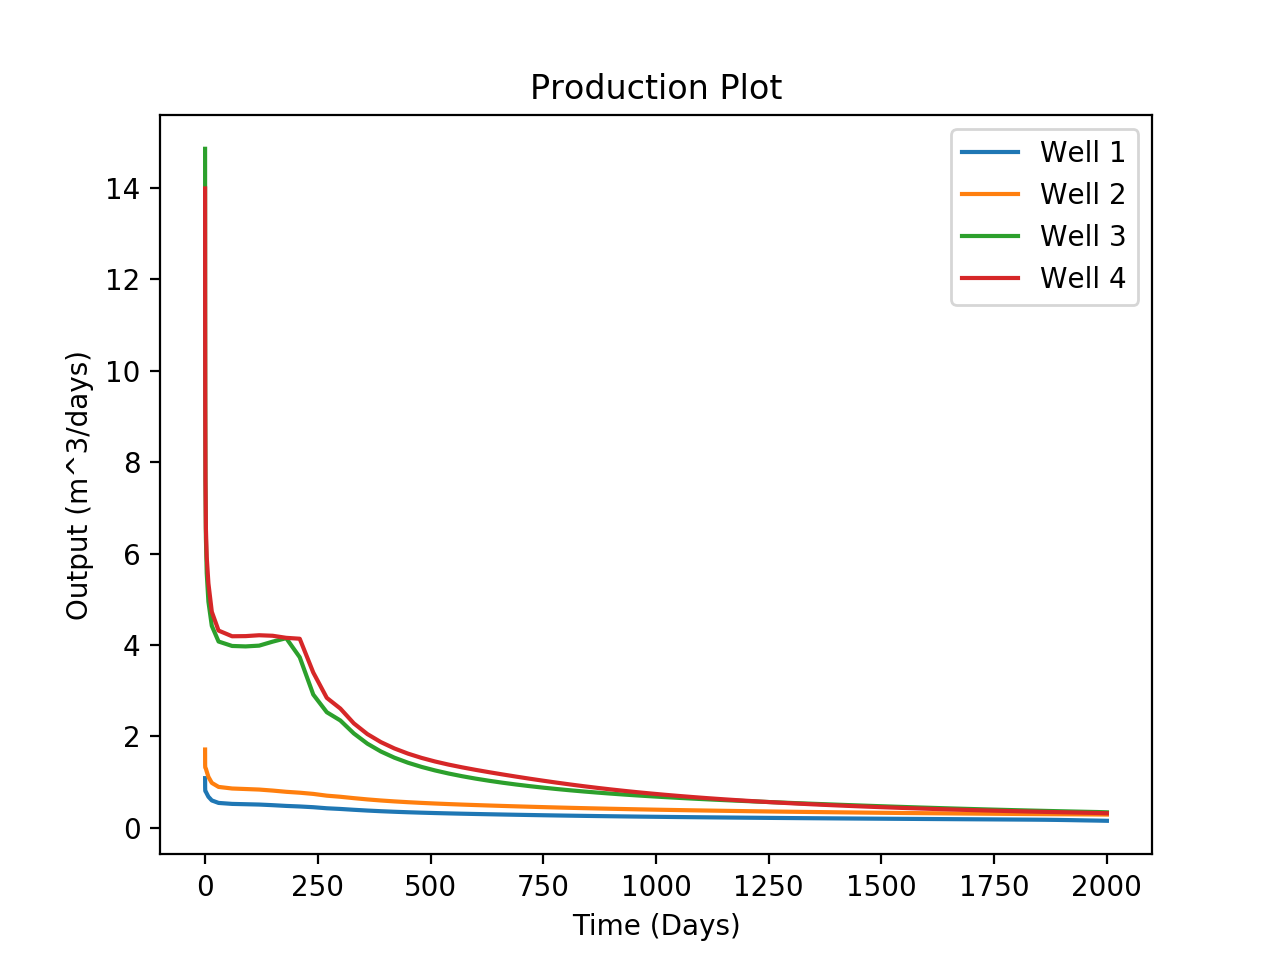

In [2]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + '/production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

In [3]:
# Specify files to read for testing and training
train_files = np.arange(1,81)
test_files = np.arange(81,101)
# # pull porosity from Rock files
# RTRAIN = pullporosity(ROCK_PATH, train_files)
# RTEST = pullporosity(ROCK_PATH, test_files)
# # reshape porosity data to feed into autoencoder (channel last)
# Rtrain = RTRAIN
# Rtest = RTEST
# Rtrain_reshaped = np.reshape(Rtrain,(len(Rtrain), 60, 220, 1),order= 'F')
# Rtest_reshaped = np.reshape(Rtest,(len(Rtest), 60, 220, 1),order= 'F')
# pull saturation data
STRAIN = pullseries(SATURATION_PATH, 'saturaton', train_files)
STEST = pullseries(SATURATION_PATH, 'saturaton', test_files)

Strain = STRAIN
Stest = STEST
Strain_reshaped = np.reshape(Strain,(len(Strain), 60, 220, 1),order= 'F')
Stest_reshaped = np.reshape(Stest,(len(Stest), 60, 220, 1),order= 'F')

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard

def retrieve_coders(name,encoded_shape):
    # check what encoded shape is first
    # default (8,28,8)
    autoencoder = load_model(name+'autoencoder.h5')
    encoded_input = Input(shape=encoded_shape)
    deco = autoencoder.layers[-7](encoded_input)
    deco = autoencoder.layers[-6](deco)
    deco = autoencoder.layers[-5](deco)
    deco = autoencoder.layers[-4](deco)
    deco = autoencoder.layers[-3](deco)
    deco = autoencoder.layers[-2](deco)
    deco = autoencoder.layers[-1](deco)
    # create the decoder model
    decoder = Model(encoded_input, deco)
    # decoder.summary()
#     decoder.summary()

    input_img = Input(shape=(60, 220, 1))
    enco = autoencoder.layers[1](input_img)
    enco = autoencoder.layers[2](enco)
    enco = autoencoder.layers[3](enco)
    enco = autoencoder.layers[4](enco)
    enco = autoencoder.layers[5](enco)
    enco = autoencoder.layers[6](enco)
    encoder = Model(input_img, enco)
#     encoder.summary()
    return decoder, encoder, autoencoder

Using TensorFlow backend.


In [8]:
# retrieve autoencoders that are trained on AWS
# Rdecoder, Rencoder, Rautoencoder = retrieve_coders('R', (8,28,4))
Sencoded_shape = (8,28,8)
Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', (8,28,8))
Sautoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 60, 220, 1)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 60, 220, 16)       2128      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 110, 16)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 30, 110, 8)        1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 55, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 15, 55, 8)         584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 28, 8)          0         
__________

<IPython.core.display.Javascript object>


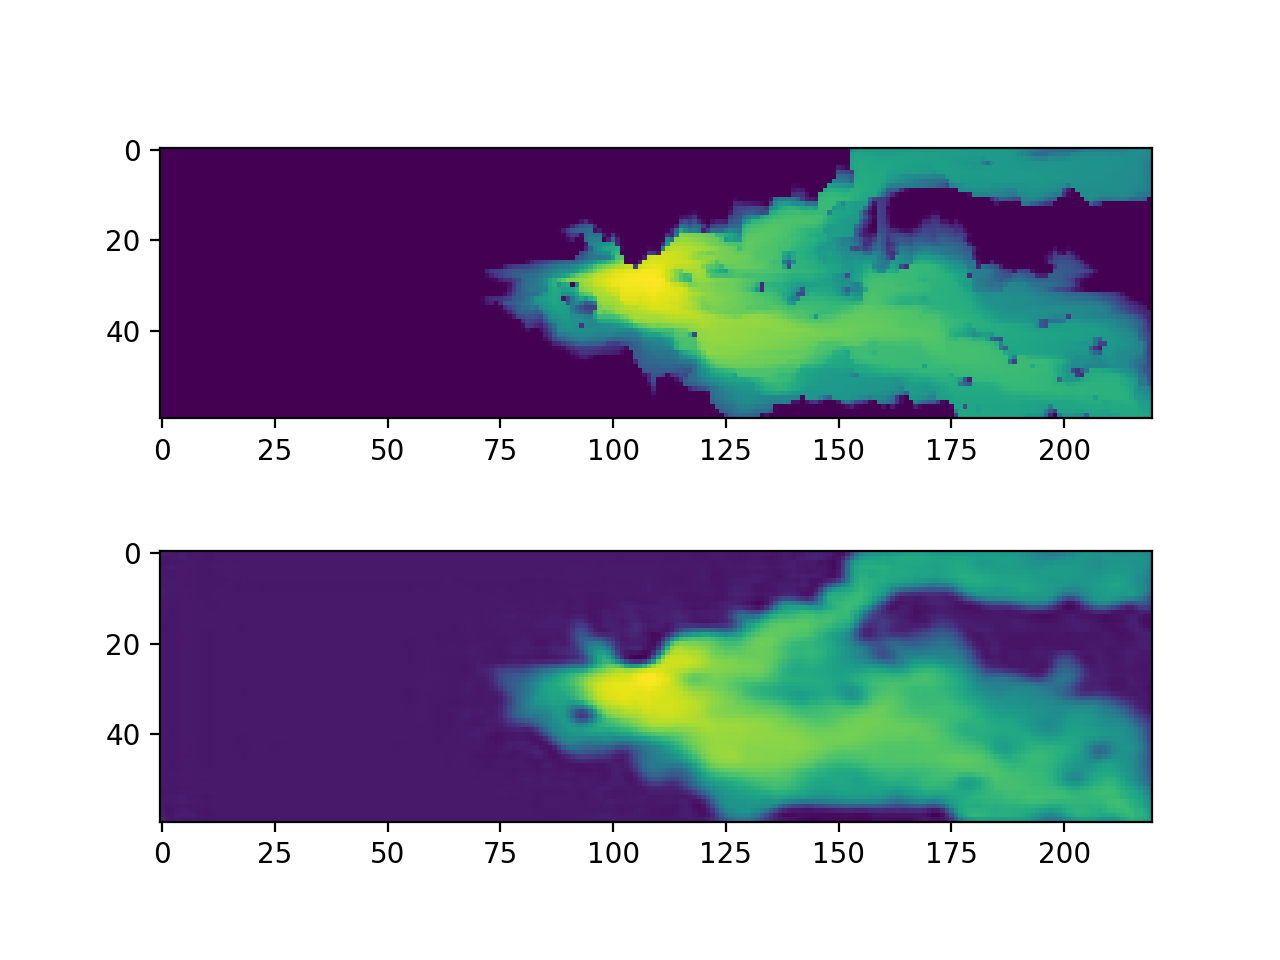

In [6]:
# check trained autoencoders
interval = np.arange(0,75)

decoded_Saturation = Sautoencoder.predict(Stest_reshaped[interval,])
animate_compare(Stest_reshaped[interval,],decoded_Saturation[:,])

# interval = np.arange(0,10)
# decoded_Rock = Rautoencoder.predict(Rtest_reshaped[interval,])
# animate_compare(Rtest_reshaped[interval,],decoded_Rock[:,])

In [7]:
from sklearn.preprocessing import MinMaxScaler

# def change_sampling_rate(DATA,sampling_rate):
#     # DATA: [n x (60*220)], n is original total sample size,75 is the original batch size
#     batch_size = int(75/sampling_rate) # new batch size
#     New_Data = []
#     for i in range(int(len(DATA)/75)):
#         temp = []
#         for index in range(batch_size):
#             temp.append(DATA[i*75+index*sampling_rate])
#         temp = np.stack(temp)
#         New_Data.append(temp)
#     New_Data = np.concatenate(New_Data,axis=0)
#     return New_Data, batch_size

def crop_data(DATA,start,end,batch_size):
    # DATA: encoded or original data for Saturation/Pressure
    # recommend start = 10, end = 71 (non-inclusive end)
    if end-start>batch_size:
        print('ERROR: batch size too large for specified start and end...')
        return 0
    samples = int(DATA.shape[0]/batch_size)
    cropped_DATA = []
    for i in range(samples):
        cropped_DATA.append(DATA[i*batch_size+start:i*batch_size+end,])
    cropped_DATA = np.concatenate(cropped_DATA)
    batch_size = end-start
    return cropped_DATA, batch_size


def add_setup_data(DATA, RDATA, batch_size):
    # concatenate porosity data with states data (in encoded space)
    # [state at t1, porosity 1; state at t2, porosity 2]
    n = int(len(DATA)/batch_size) # the number of simulations
    if n != len(RDATA):
        print('ERROR: Porosity data does not match States data in length..')
        return 0
    Concatenated_Data = []
    for i in range(n):
        for j in range(batch_size):
            temp = np.concatenate([DATA[i*batch_size+j],RDATA[i]],axis=-1)
            Concatenated_Data.append(temp)
    return np.stack(Concatenated_Data)
    

def create_dataset(Batch_Data, window_len, sampling_rate):
    """
    Batch Data must be inputed
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    
    added rate for different sampling rates
    """
    X_new = []
    y_new = []
    sample_list = np.array([i*sampling_rate for i in range(window_len)])
    for index in range(len(Batch_Data) - window_len*sampling_rate):        
        X_new.append(Batch_Data[index+sample_list])
        y_new.append(Batch_Data[index+window_len*sampling_rate])
    X_new = np.stack(X_new)
    y_new = np.stack(y_new)
    return X_new,y_new

# def scale_data(X):
#     # input original dataset samples X (x*y)
#     # return normalized data and the corresponding scaler
#     scaler = MinMaxScaler()
#     scaler = scaler.fit(X)
#     print('Min:', scaler.data_min_[0:3], '\nMax: ',scaler.data_max_[0:3])
#     normalized = scaler.transform(X)
#     return normalized, scaler

def prepare_RNN_data(Encoded_data,lookback,batch_size,sampling_rate):
    # assume input is encoded and outputs the tuple containing X and Y for training/ testing
    Out_X = []
    Out_y = []
    if lookback>batch_size:
        print('ERROR: Lookback window size is larger than updated batch size..')
        return 0
    for i in range(int(len(Encoded_data)/batch_size)):
        X_temp, y_temp = create_dataset(Encoded_data[i*batch_size:(i+1)*batch_size,:],lookback, sampling_rate)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)


In [8]:
# Rtrain_encoded = Rencoder.predict(Rtrain_reshaped)
# Rtest_encoded = Rencoder.predict(Rtest_reshaped)
# # change sampling rate of saturation states 
# batch_size = 75 # default value
# sampling_rate = 1 # default = 1
# Stest_updated, batch_size = change_sampling_rate(Stest_reshaped,sampling_rate)
# Strain_updated, batch_size = change_sampling_rate(Strain_reshaped,sampling_rate)
# print(Strain_updated.shape)
# # encode training and testing data
# Strain_encoded = Sencoder.predict(Strain_updated)
# Stest_encoded = Sencoder.predict(Stest_updated)
# print(Strain_encoded.shape, Rtrain_encoded.shape)
# # update encoded space by padding with setup porosity
# Stest_stacked_encoded = add_setup_data(Stest_encoded, Rtest_encoded, batch_size)
# Strain_stacked_encoded = add_setup_data(Strain_encoded, Rtrain_encoded, batch_size)

(6000, 60, 220, 1)
(6000, 8, 28, 8) (80, 8, 28, 4)


In [19]:
from numpy import linalg as LA
def updateX(model,X_current,lookback,Porosity_encoded,STATE_encoded_shape):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
#     print('X_now:',X_current.shape)
    
    if Porosity_encoded !=[]:
        temp = []
        for i in range(len(X_current)):
            temp.append(np.concatenate([X_current[i], Porosity_encoded],axis=-1))
        X_stacked = np.stack(temp)
    else:
        X_stacked = X_current
#     print(X_current.shape)
    X_c_train = np.expand_dims(X_stacked, axis=0)
    x_stacked_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    x_plusone = x_stacked_plusone[:,:,:,0:STATE_encoded_shape[-1]]
    if lookback == 1:
        X_next = x_plusone
    else:
#         print(X_current[1:,].shape,x_plusone.shape)
        X_next = np.vstack((X_current[1:,],x_plusone))
#         print('X_next:',X_next.shape)
    return X_next,x_plusone

def cumulative_test(X_test, y_test, original_y, lookback, RNN_model, State_decoder, STATE_encoded_shape, Porosity_encoded, batch_size):
    # perform cumulative testing
    # X_test should only have length of batch_size
    # X_test and y_test: [state_encoded]
    # error analysis and comparison will be done in the original space however
    # Porosity_encoded for the specifc interval will be used
    m = y_test.shape[0]    # total number of samples to loop through
    if m>batch_size-lookback:
        print('ERROR: X_test should have length of batch_size-lookback')
        return 0
    i = start
    X_current = X_test[start,] # both X_test should be the same
    errors = []
    predicted_y = []
    while i < m:
        X_next,y_predicted = updateX(RNN_model,X_current,lookback,Porosity_encoded)
        
        # update X and error term
        X_current = X_next
        y_predicted_original = State_decoder.predict(y_predicted)
        errors.append(LA.norm(original_y[i,]-y_predicted_original)/LA.norm(original_y[i,]))
        predicted_y.append(y_predicted_original)
        if errors[i-start] >0.2:
            predicted_y = np.stack(predicted_y)
            errors = np.array(errors)
            break
        i += 1
    predicted_y = np.stack(predicted_y)
    errors = np.array(errors)
    return errors, predicted_y

def non_cumulative_test(X_test, y_test, original_y, RNN_model, State_decoder, STATE_encoded_shape, Porosity_encoded, batch_size, lookback):
    m = y_test.shape[0]    # total number of samples to loop through
    errors = np.zeros(m)
    predicted_y = np.zeros(original_y.shape)
    for i in range(m):
        _, y_predicted = updateX(RNN_model,X_test[i,],lookback, Porosity_encoded, STATE_encoded_shape)
        y_predicted_original = State_decoder.predict(y_predicted)
        errors[i] = np.average(abs(original_y[i,]-y_predicted_original))/np.max(abs(original_y[i,]))
        predicted_y[i,:] = y_predicted_original
    return errors, predicted_y



In [ ]:
batch_size = 75 # default value
start = 0
end = 75
Stest_updated, cropped_batch_size = crop_data(Stest_reshaped,start,end,batch_size)
Stest_encoded = Sencoder.predict(Stest_updated)


<IPython.core.display.Javascript object>


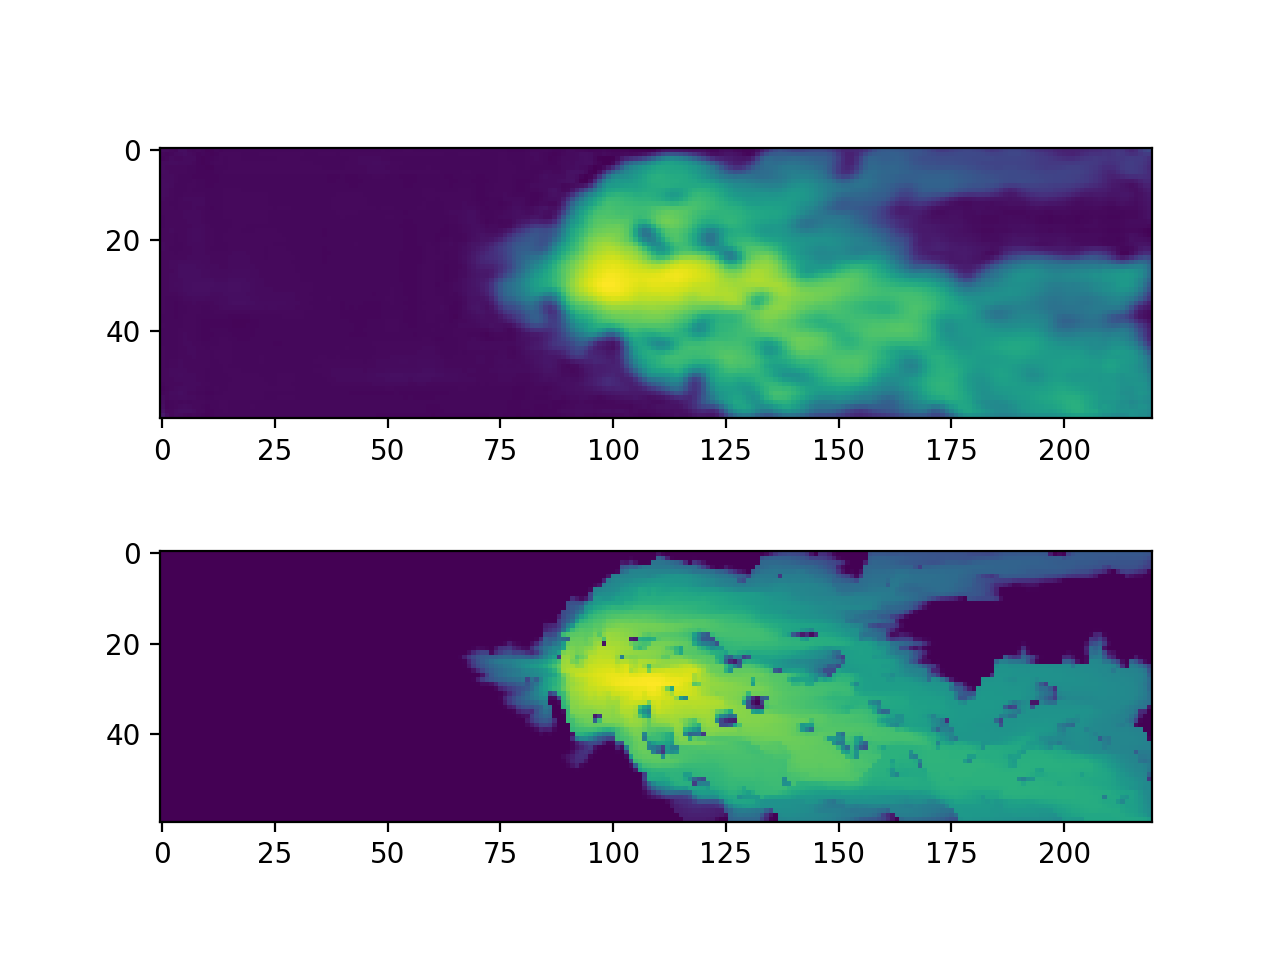

Lookback: 4 Sampling Rate: 1 Average Error: 0.028921158941672513


In [51]:
item = 2
lookback = 4
sampling_rate = 1
Incre = cropped_batch_size-lookback*sampling_rate
Interval = np.arange(cropped_batch_size*item,cropped_batch_size*(item+1))
_,original_y = prepare_RNN_data(Stest_updated[Interval,],lookback, cropped_batch_size, sampling_rate)
X,y = prepare_RNN_data(Stest_encoded[Interval,],lookback, cropped_batch_size, sampling_rate)
#         print('Incre:',Incre,X.shape[0])
SRNN = load_model('SRNN_'+str(lookback)+'_'+str(sampling_rate)+'_pure.h5')
errors, predicted_y = non_cumulative_test(X, y, original_y, SRNN, 
                                      Sdecoder, Sencoded_shape, [], cropped_batch_size,lookback)
animate_compare(original_y,predicted_y)
print('Lookback:',lookback,'Sampling Rate:',sampling_rate,'Average Error:',np.average(errors))

In [49]:
item = 3
legend_names = []
plot_errors = []
plot_steps = []
for lookback in range(2,6):
    for sampling_rate in range(1,5):
        Incre = cropped_batch_size-lookback*sampling_rate
        Interval = np.arange(cropped_batch_size*item,cropped_batch_size*(item+1))
        _,original_y = prepare_RNN_data(Stest_updated[Interval,],lookback, cropped_batch_size, sampling_rate)
        X,y = prepare_RNN_data(Stest_encoded[Interval,],lookback, cropped_batch_size, sampling_rate)
#         print('Incre:',Incre,X.shape[0])
        SRNN = load_model('SRNN_'+str(lookback)+'_'+str(sampling_rate)+'_pure.h5')
        errors, predicted_y = non_cumulative_test(X, y, original_y, SRNN, 
                                              Sdecoder, Sencoded_shape, [], cropped_batch_size,lookback)
#         animate_compare(predicted_y,original_y)
        plot_errors.append(errors)
        plot_steps.append(np.arange(len(errors))+lookback*sampling_rate+1)
        legend_names.append('L'+str(lookback)+'S'+str(sampling_rate))
        print('Lookback:',lookback,'Sampling Rate:',sampling_rate,'Average Error:',np.average(errors))


Lookback: 2 Sampling Rate: 1 Average Error: 0.046693445432114684
Lookback: 2 Sampling Rate: 2 Average Error: 0.04959888526723838
Lookback: 2 Sampling Rate: 3 Average Error: 0.05592808867737219
Lookback: 2 Sampling Rate: 4 Average Error: 0.05474444348782079
Lookback: 3 Sampling Rate: 1 Average Error: 0.046857092896566935
Lookback: 3 Sampling Rate: 2 Average Error: 0.0524567158697038
Lookback: 3 Sampling Rate: 3 Average Error: 0.05285362326398944
Lookback: 3 Sampling Rate: 4 Average Error: 0.05500108896503373
Lookback: 4 Sampling Rate: 1 Average Error: 0.0478251519527706
Lookback: 4 Sampling Rate: 2 Average Error: 0.05289495428468087
Lookback: 4 Sampling Rate: 3 Average Error: 0.057010897006543854
Lookback: 4 Sampling Rate: 4 Average Error: 0.05261877949460078
Lookback: 5 Sampling Rate: 1 Average Error: 0.05678254228883556
Lookback: 5 Sampling Rate: 2 Average Error: 0.050808320165826724
Lookback: 5 Sampling Rate: 3 Average Error: 0.05505982240041097
Lookback: 5 Sampling Rate: 4 Average E

<IPython.core.display.Javascript object>


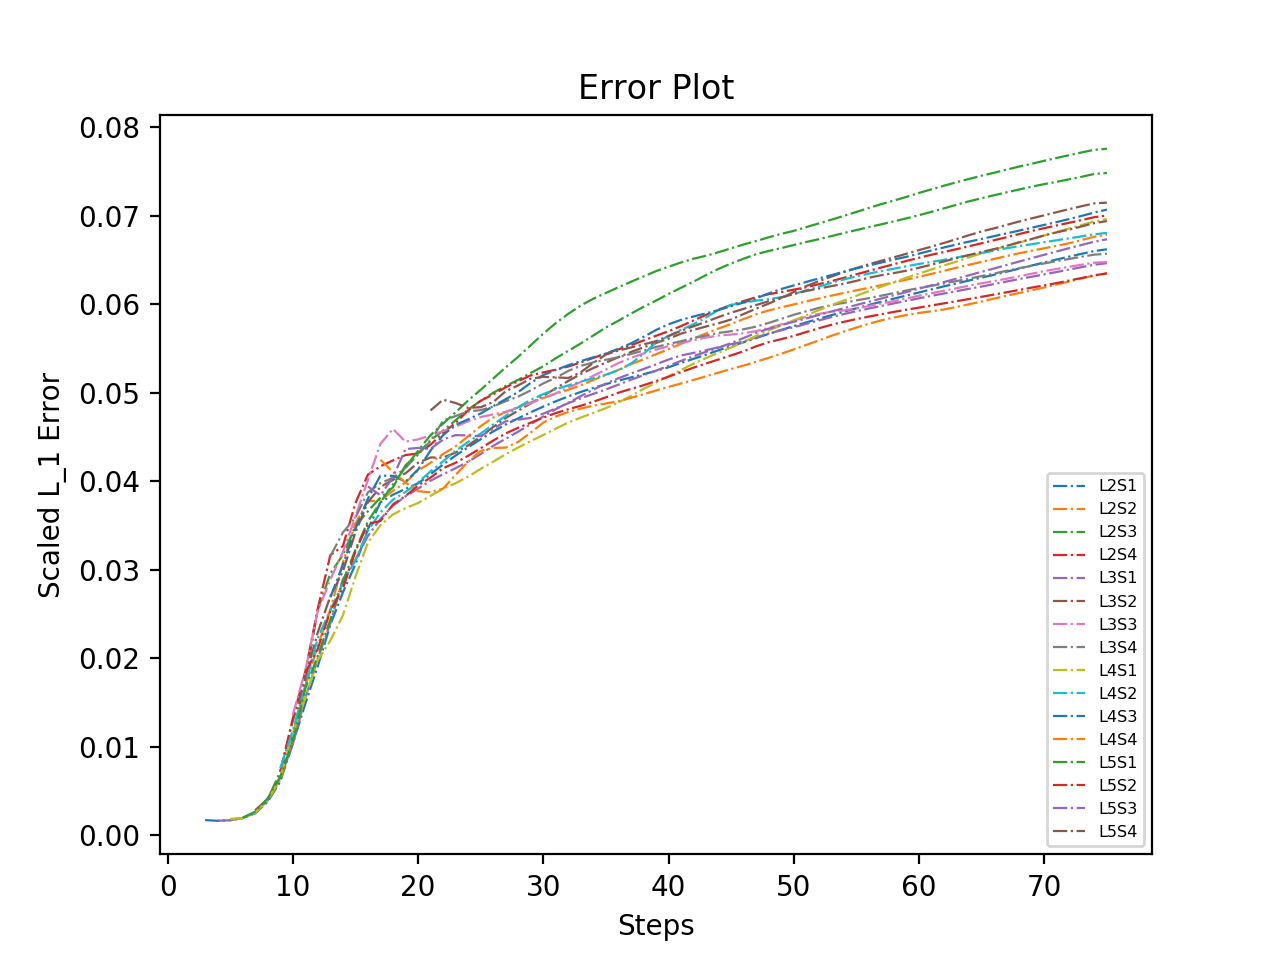

In [50]:
plt.figure()
plt.title('Error Plot')
for i in range(len(plot_steps)):
    plt.plot(plot_steps[i],plot_errors[i],'-.',lw=0.8)
plt.xlabel('Steps')
plt.ylabel('Scaled L_1 Error')
plt.legend(legend_names,loc='lower right',fontsize='xx-small')
plt.show()

<IPython.core.display.Javascript object>


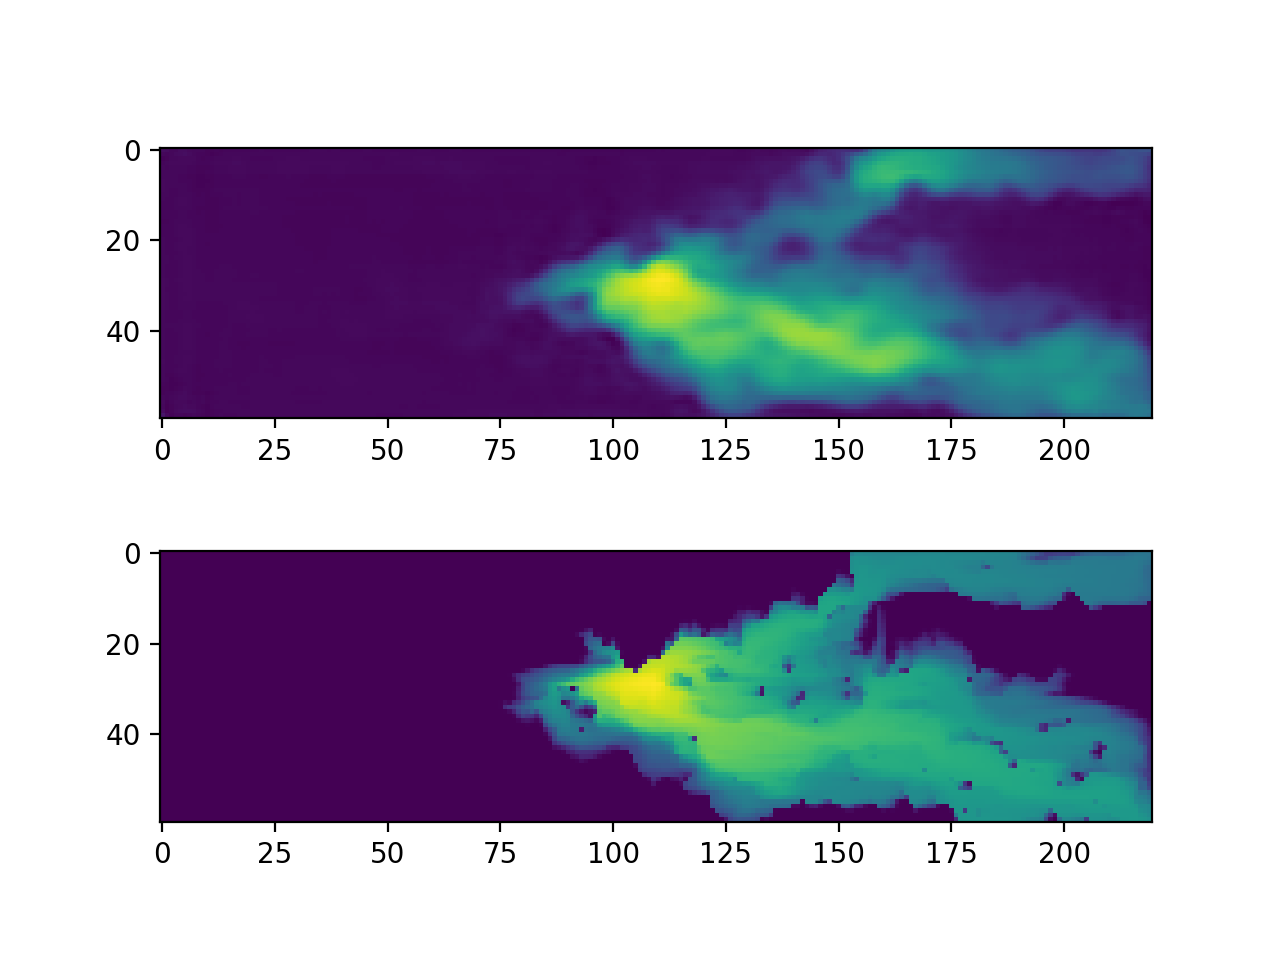

<IPython.core.display.Javascript object>


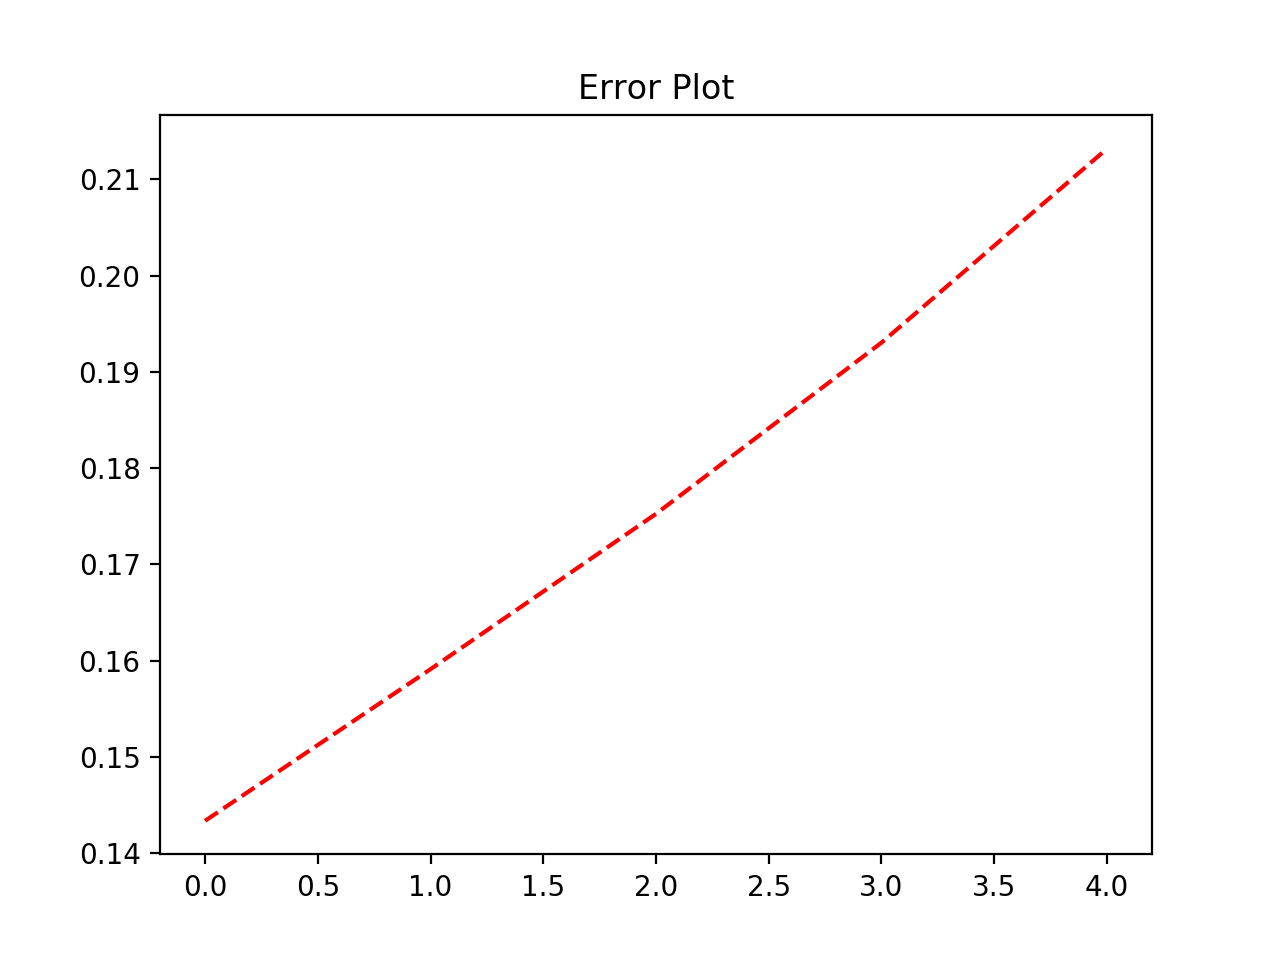

In [49]:
# # transform encoded data into trainable sets
# lookback = 1
# STRAIN = prepare_RNN_data(Strain_stacked_encoded,lookback,batch_size)
# STEST = prepare_RNN_data(Stest_stacked_encoded,lookback,batch_size)
# # prepare data for validating and visualization later
# STEST_single = prepare_RNN_data(Stest_encoded,lookback,batch_size) 
# STEST_original = prepare_RNN_data(Stest_updated,lookback,batch_size)

# # prepare for analysis, generate data for comparison
# Incre = batch_size-lookback
# X,y = STEST_single
# original_X, original_y = STEST_original
# # decoded_y = Sdecoder.predict(y)
# # print(y.shape,original_y.shape, decoded_y.shape)
# SRNN_model_one = load_model('SRNN_one.h5')
# item = 0
# Interval = np.arange(Incre*item,Incre*(item+1)) # interval for testing sequentially
# # switch out between decoded_y and original_y for different comparisons
# # cumulative test that stops at 20% error
start = 40
errors, predicted_y = cumulative_test(X[Interval,], y[Interval,], original_y[Interval,], lookback, SRNN_model_one, 
                                      Sdecoder,Rtest_encoded[item], batch_size, start)
animate_compare(predicted_y,original_y[Interval+start,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

# # non-cumulative test
# errors, predicted_y = non_cumulative_test(X[Interval,], y[Interval,], original_y[Interval,], lookback, SRNN_model_one, 
#                                       Sdecoder,Rtest_encoded[item], batch_size)
# animate_compare(predicted_y,original_y[Interval,])
# plt.figure()
# plt.title('Error Plot')
# plt.plot(np.arange(len(errors)), errors, 'r--')

<IPython.core.display.Javascript object>


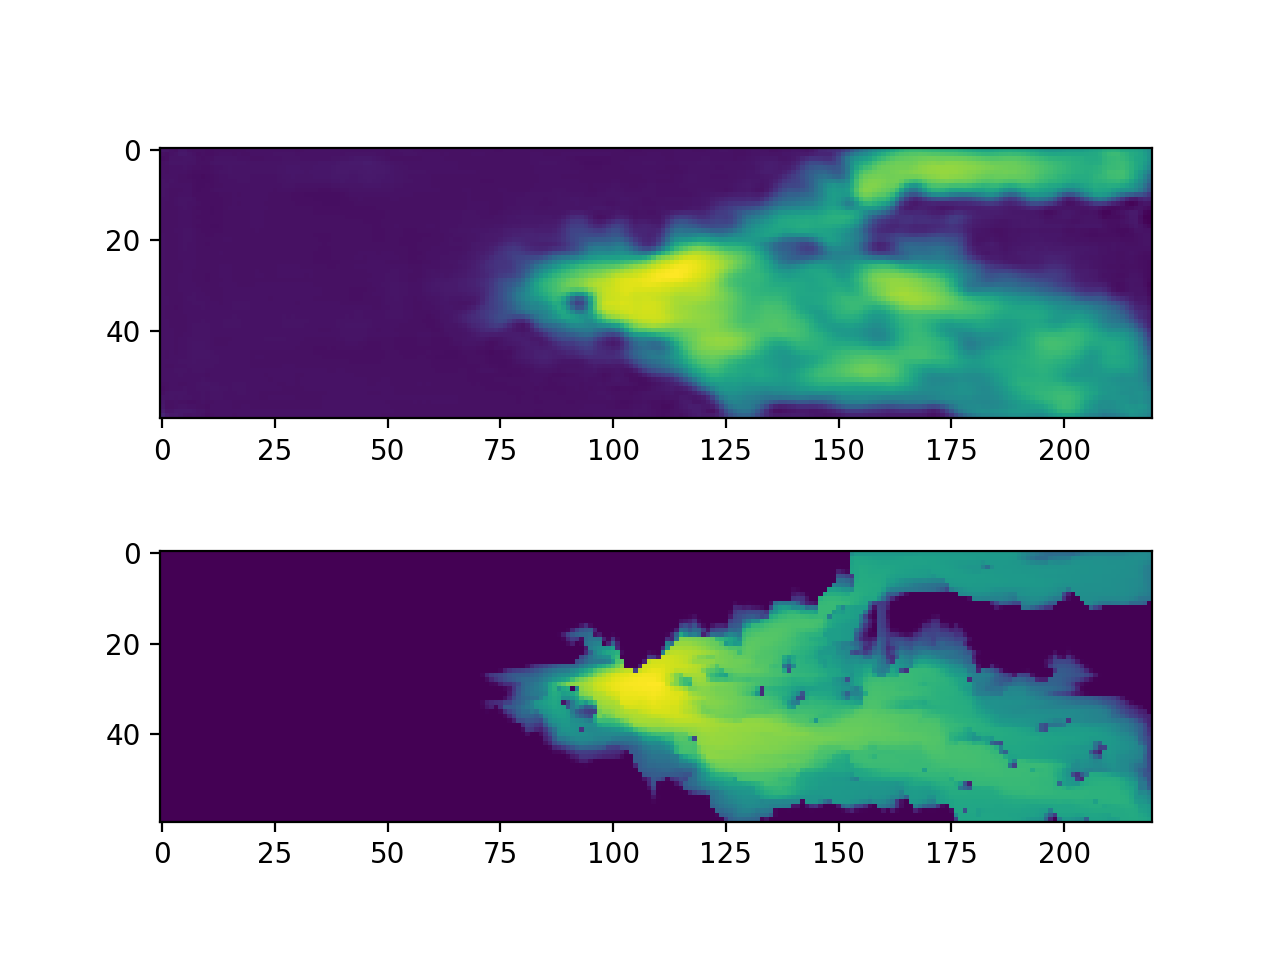

<IPython.core.display.Javascript object>


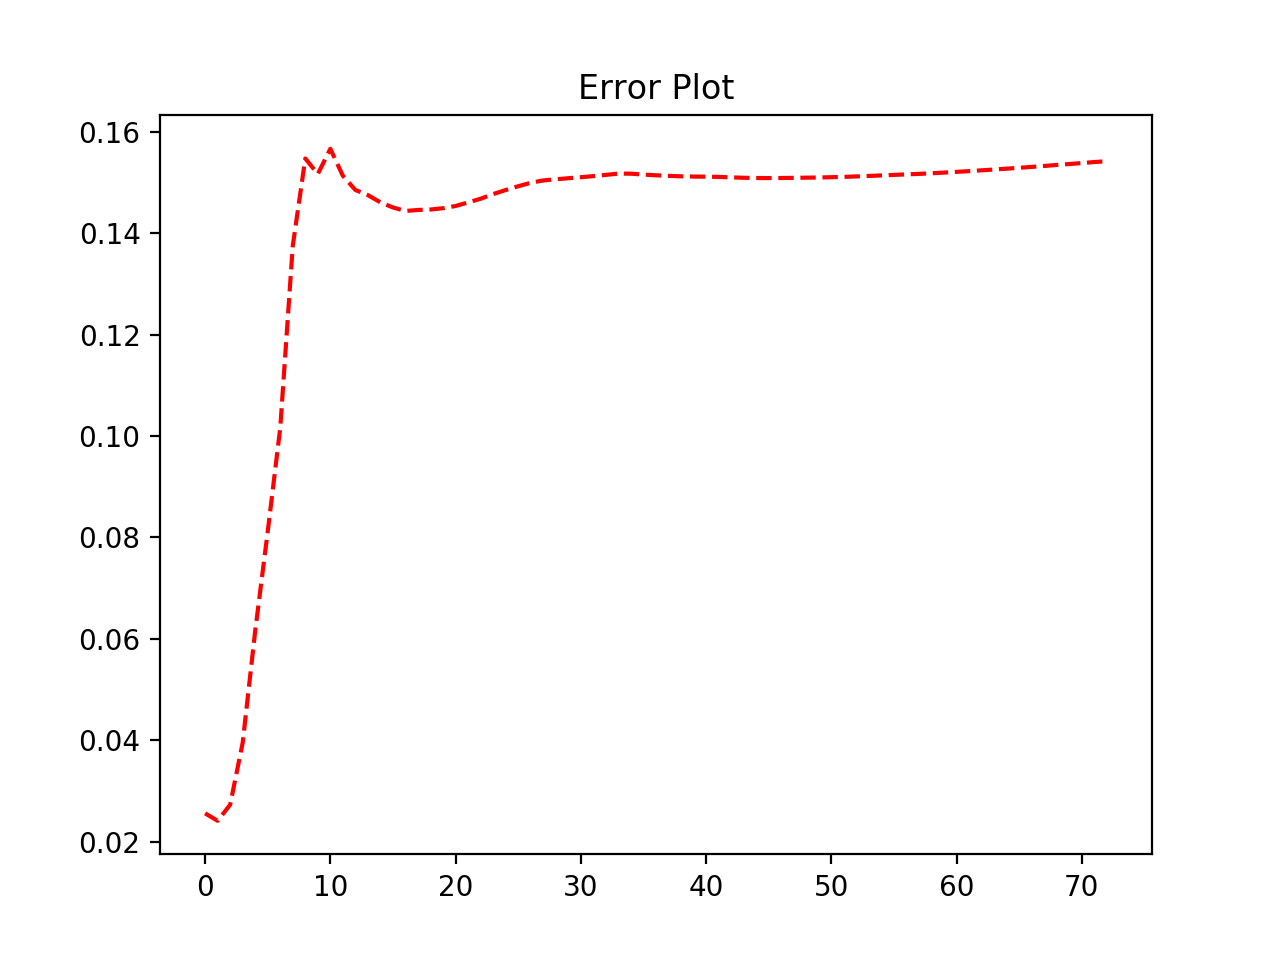

In [29]:
# transform encoded data into trainable sets
lookback = 2
STRAIN = prepare_RNN_data(Strain_stacked_encoded,lookback,batch_size)
STEST = prepare_RNN_data(Stest_stacked_encoded,lookback,batch_size)
# prepare data for validating and visualization later
STEST_single = prepare_RNN_data(Stest_encoded,lookback,batch_size) 
STEST_original = prepare_RNN_data(Stest_updated,lookback,batch_size)

# prepare for analysis, generate data for comparison
Incre = batch_size-lookback
X,y = STEST_single
original_X, original_y = STEST_original
# decoded_y = Sdecoder.predict(y)
# print(y.shape,original_y.shape, decoded_y.shape)

SRNN_model_two = load_model('SRNN.h5')
item = 0
Interval = np.arange(Incre*item,Incre*(item+1)) # interval for testing sequentially
# switch out between decoded_y and original_y for different comparisons
errors, predicted_y = non_cumulative_test(X[Interval,], y[Interval,], original_y[Interval,], lookback, SRNN_model_two, 
                                      Sdecoder,Rtest_encoded[item], batch_size)
animate_compare(predicted_y,original_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')